In [1]:
import pandas as pd
import glob
import os

directory_hps = 'HPS'
os.chdir(directory_hps)
all_filenames_hps = glob.glob("*.csv")

combined_hps_df = pd.concat([pd.read_csv(f) for f in all_filenames_hps], ignore_index=True)

# Save the combined file
combined_hps_df.to_csv("combined_hps.csv", index=False)


In [2]:
excel_files = glob.glob("../Telework/*.xlsx")
combined_sheets = {}

# Get all sheet names from the first file
all_sheet_names = pd.ExcelFile(excel_files[0]).sheet_names

# For each sheet, combine data across files
for sheet in all_sheet_names:
    frames = []
    for file in excel_files:
        month = file.split('-')[-1].replace('.xlsx', '') # Adjust for filename
        df = pd.read_excel(file, sheet_name=sheet)
        df['Month'] = month
        frames.append(df)
    combined_sheets[sheet] = pd.concat(frames, ignore_index=True)

# Write to a single Excel file with one sheet per sheet name
with pd.ExcelWriter('combined-telework-tables.xlsx') as writer:
    for sheet, df in combined_sheets.items():
        df.to_excel(writer, sheet_name=sheet, index=False)


In [11]:

# Load Pulse microdata (individual-level)
pulse_df = pd.read_csv('/Users/khushichavan/data_science_1st_semester/foundations_of_data_science/final_project/HPS/combined_hps.csv', low_memory=False)

# Derive AGE
pulse_df['AGE'] = 2025 - pulse_df['TBIRTH_YEAR']

# Basic cleaning: drop impossible/invalid values
pulse_clean = pulse_df[
    (pulse_df['AGE'] > 17) &
    (pulse_df['WRKLOSSRV'] >= 0) &
    (pulse_df['SOCIAL1'] >= 0) &
    (pulse_df['INCOME'] > 0)
]

# Select columns for EDA/modeling (adjust to actual shared column)
pulse_clean = pulse_clean[['REGION', 'AGE', 'INCOME', 'WRKLOSSRV', 'SOCIAL1']].dropna()


              REGION            AGE         INCOME      WRKLOSSRV  \
count  503363.000000  503363.000000  503363.000000  503363.000000   
mean        2.696319      55.275638       4.672829       1.905402   
std         1.066406      15.764234       2.182512       0.292659   
min         1.000000      19.000000       1.000000       1.000000   
25%         2.000000      42.000000       3.000000       2.000000   
50%         3.000000      56.000000       5.000000       2.000000   
75%         4.000000      68.000000       6.000000       2.000000   
max         4.000000      89.000000       8.000000       2.000000   

             SOCIAL1  
count  503363.000000  
mean        2.265069  
std         1.145273  
min         1.000000  
25%         1.000000  
50%         2.000000  
75%         3.000000  
max         5.000000  


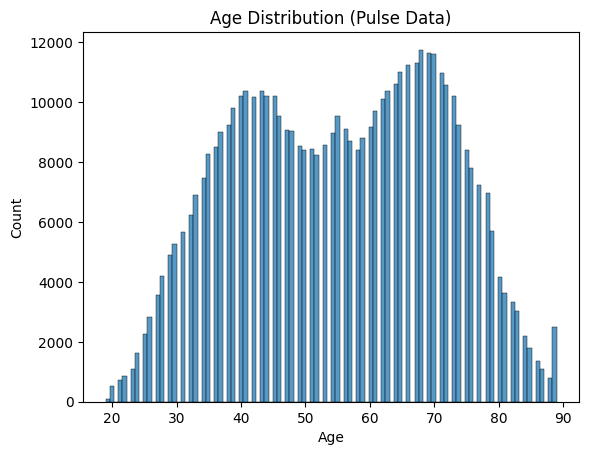

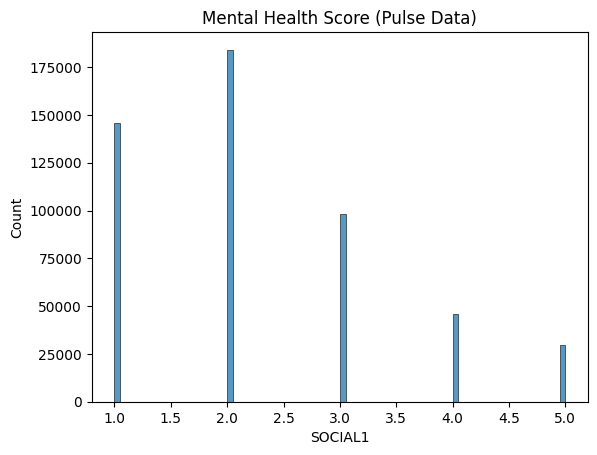

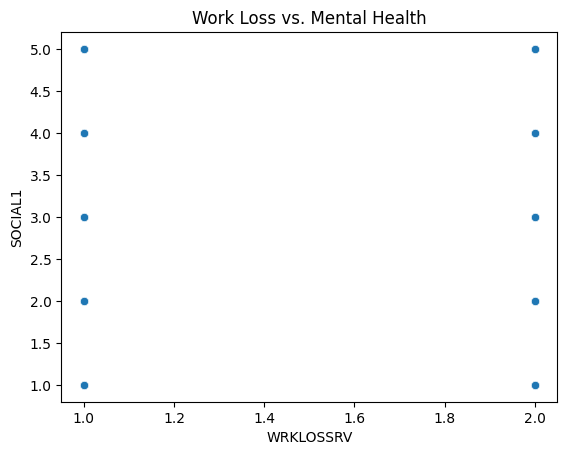

             REGION       AGE    INCOME  WRKLOSSRV   SOCIAL1
REGION     1.000000  0.004018  0.000512  -0.007514  0.001218
AGE        0.004018  1.000000 -0.144761   0.074117 -0.159402
INCOME     0.000512 -0.144761  1.000000   0.121818 -0.174356
WRKLOSSRV -0.007514  0.074117  0.121818   1.000000 -0.121918
SOCIAL1    0.001218 -0.159402 -0.174356  -0.121918  1.000000


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Describe and visualize distributions
print(pulse_clean.describe())

# AGE distribution
sns.histplot(pulse_clean['AGE'])
plt.title('Age Distribution (Pulse Data)')
plt.xlabel('Age')
plt.show()

# Mental health distribution
sns.histplot(pulse_clean['SOCIAL1'])
plt.title('Mental Health Score (Pulse Data)')
plt.xlabel('SOCIAL1')
plt.show()

# Scatter: Work Loss vs. Mental Health
sns.scatterplot(x='WRKLOSSRV', y='SOCIAL1', data=pulse_clean)
plt.title('Work Loss vs. Mental Health')
plt.show()

# Correlation matrix
print(pulse_clean.corr())


In [13]:
# Load CPS telework table (aggregate)
cps_df = pd.read_excel('/Users/khushichavan/data_science_1st_semester/foundations_of_data_science/final_project/Telework/combined-telework-tables.xlsx', sheet_name=3)

# Basic cleaning: keep only match-able fields, remove NAs
cps_clean = cps_df[['Region', 'Telework Rate']].dropna()  # Substitute with actual shared key

# Summarize and visualize
print(cps_clean.describe(include='all'))

sns.histplot(cps_clean['Telework Rate'])
plt.title('Telework Rate Distribution (CPS)')
plt.xlabel('Telework Rate')
plt.show()


KeyError: "None of [Index(['Region', 'Telework Rate'], dtype='object')] are in the [columns]"

In [ ]:
# Aggregate Pulse data by REGION
pulse_group = pulse_clean.groupby('REGION').agg({
    'AGE': 'mean',
    'INCOME': 'mean',
    'WRKLOSSRV': 'mean',
    'SOCIAL1': 'mean',
    'REGION': 'count'
}).reset_index().rename(columns={'REGION': 'N'})

# Merge with CPS telework data
merged = pd.merge(pulse_group, cps_clean, left_on='REGION', right_on='Region', how='inner')

print(merged.head())


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Prepare features and target for modeling
features = ['Telework Rate', 'AGE', 'INCOME', 'WRKLOSSRV']
X = merged[features]
y = merged['SOCIAL1']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data (70/30)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Model Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Test MSE:', mse)
print('Test R²:', r2)
